In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
from torch_geometric.data import Data

import random
import pandas as pd
import torch_scatter
import torch.nn as nn
from torch.nn import Linear, Sequential, LayerNorm, ReLU, BatchNorm1d, Softmax, LeakyReLU
from torch.utils.data import random_split
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

In [3]:
import args
from trainer import neuralGNN

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'

In [5]:
supernode_indices = np.load('supernode_indices_amsgrad2.npy')

In [6]:
model = neuralGNN(time_window_size=args.time_window_size,
                      proc_nlp_hidden_dim=args.proc_nlp_hidden_dim,
                      time_nlp_hidden_dim=args.time_nlp_hidden_dim,
                      num_supernodes=len(supernode_indices),
                      super_nlp_hidden_dim_1=args.super_nlp_hidden_dim_1,
                      super_nlp_hidden_dim_2=args.super_nlp_hidden_dim_2,
                      num_layers=args.num_layers).to(device)

model.load_state_dict(torch.load('model_amsgrad2.pt'))
model.eval()

neuralGNN(
  (processor): ModuleList(
    (0): ProcessorLayer(21, 21)
    (1): ProcessorLayer(21, 21)
    (2): ProcessorLayer(21, 21)
    (3): ProcessorLayer(21, 21)
    (4): ProcessorLayer(21, 21)
  )
  (time_compress_mlp): Sequential(
    (0): Linear(in_features=21, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
  (supernode_mlp): Sequential(
    (0): Linear(in_features=466, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [7]:
#Get the test dataset
torch.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

dataset = torch.load('/workspace/data_gen/pupil_xcoord_graphs.pt')

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=True)

In [8]:
#Use the trained model to compile a list of the predicted labels for each graph in the test dataset
gt_labels = []
pred_labels = []

total_num_epochs = len(test_loader)

for i, data in enumerate(test_loader):
    print('Epoch: {}/{}'.format(i, total_num_epochs))

    data = data.to(device)
    gt_labels.append(data.y.cpu().numpy())
    pred_labels.append(model(data, supernode_indices, device).cpu().detach().numpy())

Epoch: 0/434
Epoch: 1/434
Epoch: 2/434
Epoch: 3/434
Epoch: 4/434
Epoch: 5/434
Epoch: 6/434
Epoch: 7/434
Epoch: 8/434
Epoch: 9/434
Epoch: 10/434
Epoch: 11/434
Epoch: 12/434
Epoch: 13/434
Epoch: 14/434
Epoch: 15/434
Epoch: 16/434
Epoch: 17/434
Epoch: 18/434
Epoch: 19/434
Epoch: 20/434
Epoch: 21/434
Epoch: 22/434
Epoch: 23/434
Epoch: 24/434
Epoch: 25/434
Epoch: 26/434
Epoch: 27/434
Epoch: 28/434
Epoch: 29/434
Epoch: 30/434
Epoch: 31/434
Epoch: 32/434
Epoch: 33/434
Epoch: 34/434
Epoch: 35/434
Epoch: 36/434
Epoch: 37/434
Epoch: 38/434
Epoch: 39/434
Epoch: 40/434
Epoch: 41/434
Epoch: 42/434
Epoch: 43/434
Epoch: 44/434
Epoch: 45/434
Epoch: 46/434
Epoch: 47/434
Epoch: 48/434
Epoch: 49/434
Epoch: 50/434
Epoch: 51/434
Epoch: 52/434
Epoch: 53/434
Epoch: 54/434
Epoch: 55/434
Epoch: 56/434
Epoch: 57/434
Epoch: 58/434
Epoch: 59/434
Epoch: 60/434
Epoch: 61/434
Epoch: 62/434
Epoch: 63/434
Epoch: 64/434
Epoch: 65/434
Epoch: 66/434
Epoch: 67/434
Epoch: 68/434
Epoch: 69/434
Epoch: 70/434
Epoch: 71/434
Ep

In [9]:
gt_labels = np.concatenate(gt_labels)
pred_labels = np.concatenate(pred_labels)

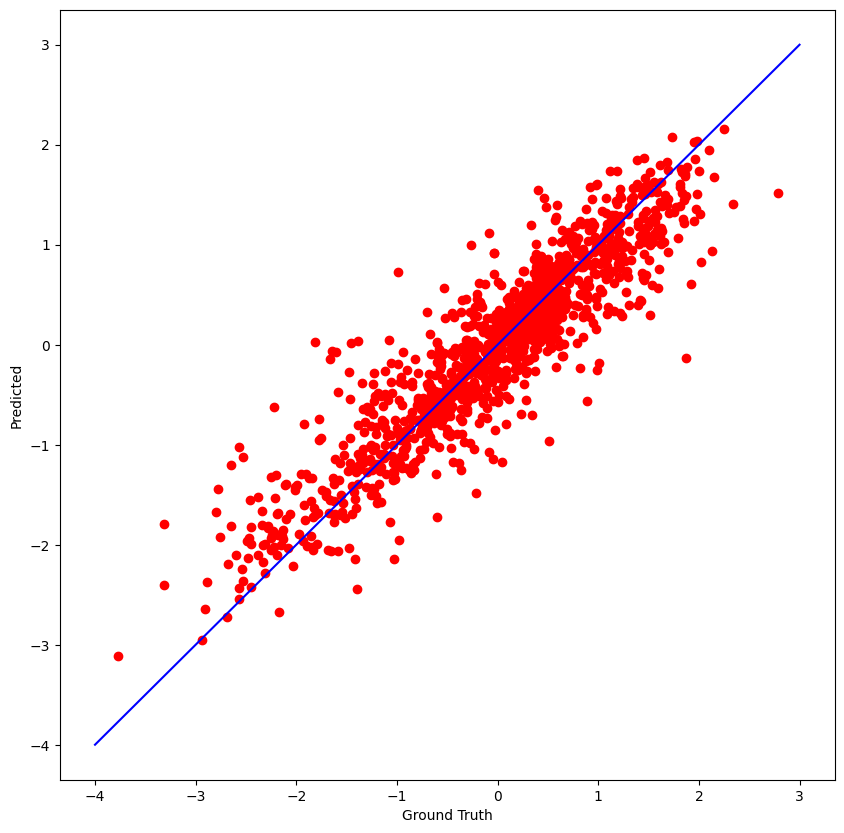

In [9]:
#Plot the predicted as a function of the ground truth.
#Add a line to show the ideal prediction
plt.figure(figsize=(10, 10))
plt.scatter(gt_labels, pred_labels, c='r')
plt.plot([-4, 3], [-4, 3], c='b')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted')
plt.show()


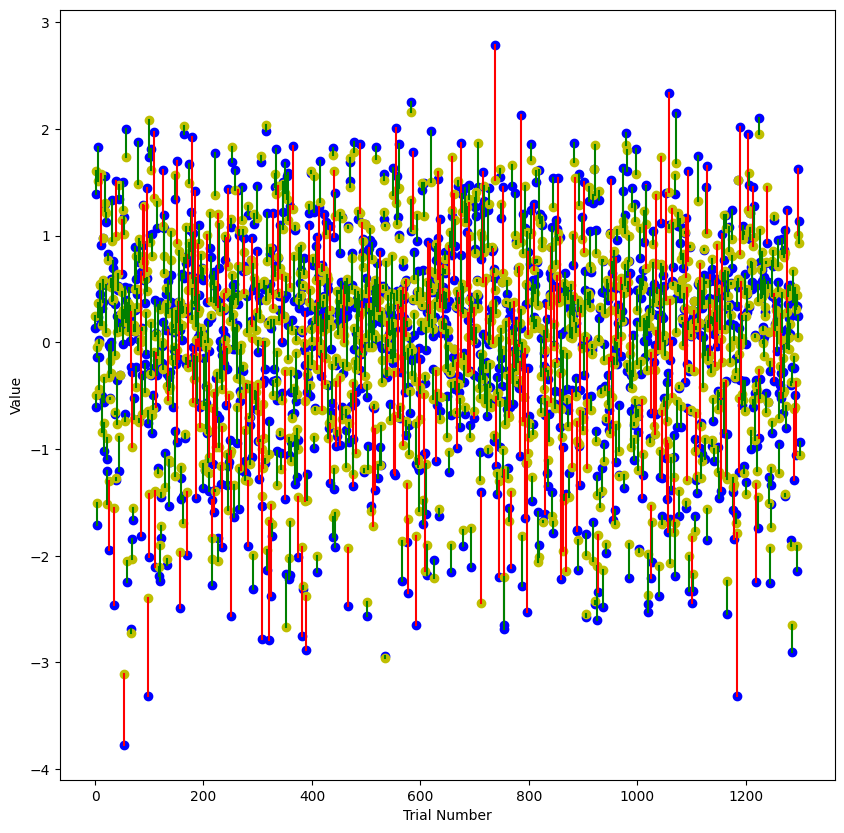

Number of green lines: 1064
Number of red lines: 236


In [10]:
#Plt the predicted values as yellow dots and the ground truth as blue dots
#The x axis is the trial number, and the y axis is the value
#For each trial, add a vertical line that connects the predicted and ground truth values.
#Make the line green if the predicted value is within 0.5 of the ground truth value, and red otherwise.
plt.figure(figsize=(10, 10))
plt.scatter(np.arange(len(gt_labels)), gt_labels, c='b')
plt.scatter(np.arange(len(gt_labels)), pred_labels, c='y')
num_red = 0
num_green = 0
for i in range(len(gt_labels)):
    if abs(gt_labels[i] - pred_labels[i]) < 0.5:
        plt.plot([i, i], [gt_labels[i], pred_labels[i]], c='g')
        num_green += 1
    else:
        plt.plot([i, i], [gt_labels[i], pred_labels[i]], c='r')
        num_red += 1
plt.xlabel('Trial Number')
plt.ylabel('Value')
plt.show()

print('Number of green lines: {}'.format(num_green))
print('Number of red lines: {}'.format(num_red))

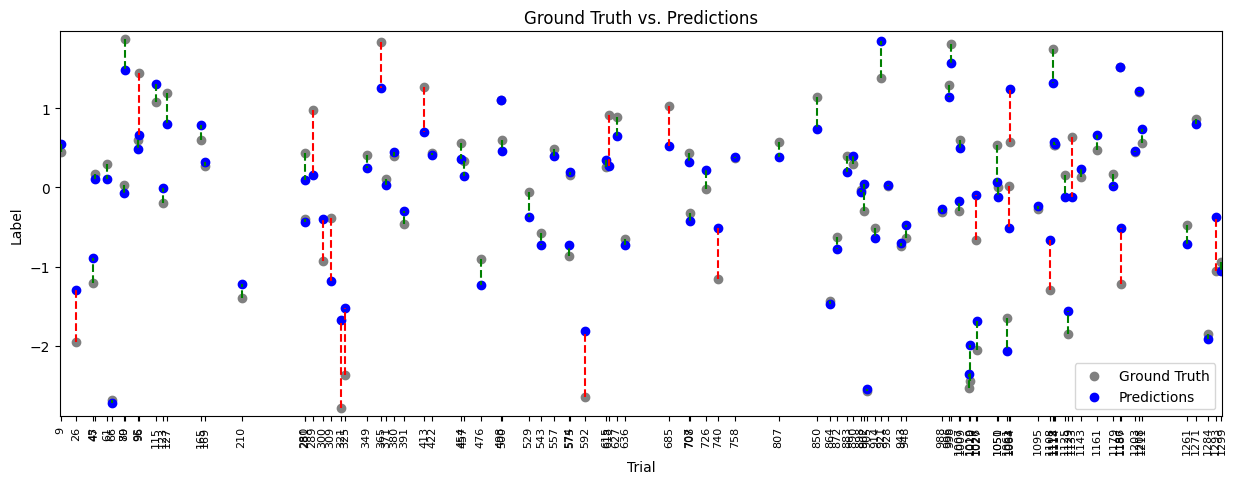

In [36]:
#Make a gif that iteratively shows the predicted and ground truth values for each trial.
#The x axis is the trial number, and the y axis is the value
#The predicted values are yellow dots, and the ground truth values are blue dots.
#For each trial, add a vertical line that connects the predicted and ground truth values.
#Make the line green if the predicted value is within 0.5 of the ground truth value, and red otherwise.
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

#Randomly select 100 trials to plot
num_trials = 100
trial_indices = sorted(np.random.choice(len(gt_labels), num_trials, replace=False))

# Index the gt_labels and pred_labels lists by trial_indices
gt_labels_subset = [gt_labels[i] for i in trial_indices]
pred_labels_subset = [pred_labels[i] for i in trial_indices]

# Create the plot
fig, ax = plt.subplots()
#ax.set_xlim([trial_indices[0], trial_indices[-1]])
min_label = min(min(gt_labels_subset), min(pred_labels_subset))
max_label = max(max(gt_labels_subset), max(pred_labels_subset))
ax.set_ylim([min_label - 0.1, max_label + 0.1])
ax.set_xlabel('Trial')
ax.set_ylabel('Label')
ax.set_title('Ground Truth vs. Predictions')

fig.set_size_inches((15, 5))

# set x-axis tick labels and positions
xtick_labels = [str(trial_indices[i]) for i in range(num_trials)]
xtick_positions = trial_indices
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=90, fontsize=8)

# set the x-axis limit
ax.set_xlim([trial_indices[0]-1, trial_indices[-1]+1])

# Plot the ground truth and predicted labels
gt_dots = ax.scatter(trial_indices, gt_labels_subset, color='gray', label='Ground Truth')
pred_dots = ax.scatter(trial_indices, pred_labels_subset, color='blue', label='Predictions')

# Add the legend
ax.legend()

# Define the update function for the animation
def update(frame):
    # Update the position and color of the ground truth dot
    gt_dots.set_offsets(np.column_stack((trial_indices[:frame+1], gt_labels_subset[:frame+1])))
    gt_dots.set_color('gray')
    
    # Update the position and color of the predicted dot
    pred_dots.set_offsets(np.column_stack((trial_indices[:frame+1], pred_labels_subset[:frame+1])))
    pred_dots.set_color('blue')
    
    # Add a vertical line that connects the prediction from the ground truth dot.
    # Make the line green if the predicted value is within 0.5 of the ground truth value, and red otherwise.
    if abs(gt_labels_subset[frame] - pred_labels_subset[frame]) < 0.5:
        ax.plot([trial_indices[frame], trial_indices[frame]], [gt_labels_subset[frame], pred_labels_subset[frame]], color='green', linestyle='dashed')
    else:
        ax.plot([trial_indices[frame], trial_indices[frame]], [gt_labels_subset[frame], pred_labels_subset[frame]], color='red', linestyle='dashed')
    
    # Return the updated artists
    return gt_dots, pred_dots,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=num_trials, interval=250, blit=True)

ani.save('ground_truth_vs_predictions.gif', writer='imagemagick')

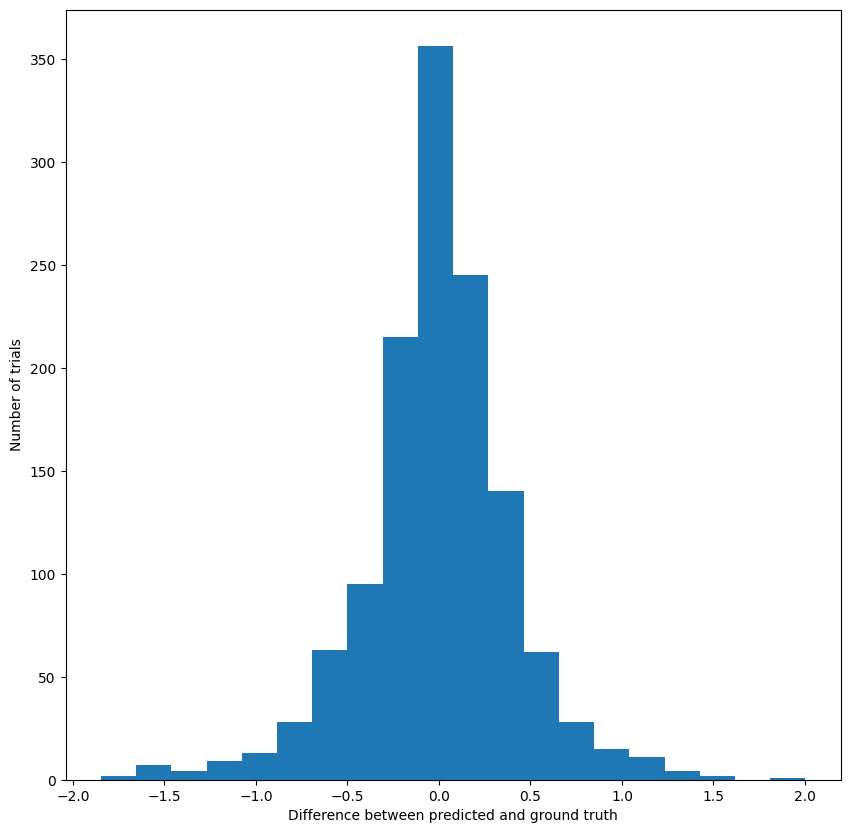

In [34]:
#Make a histogram of the difference between the predicted and ground truth values
plt.figure(figsize=(10, 10))
plt.hist(gt_labels - pred_labels, bins=20)
plt.xlabel('Difference between predicted and ground truth')
plt.ylabel('Number of trials')
plt.show()


In [41]:
print(max(gt_labels))

[2.7901409]


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7]


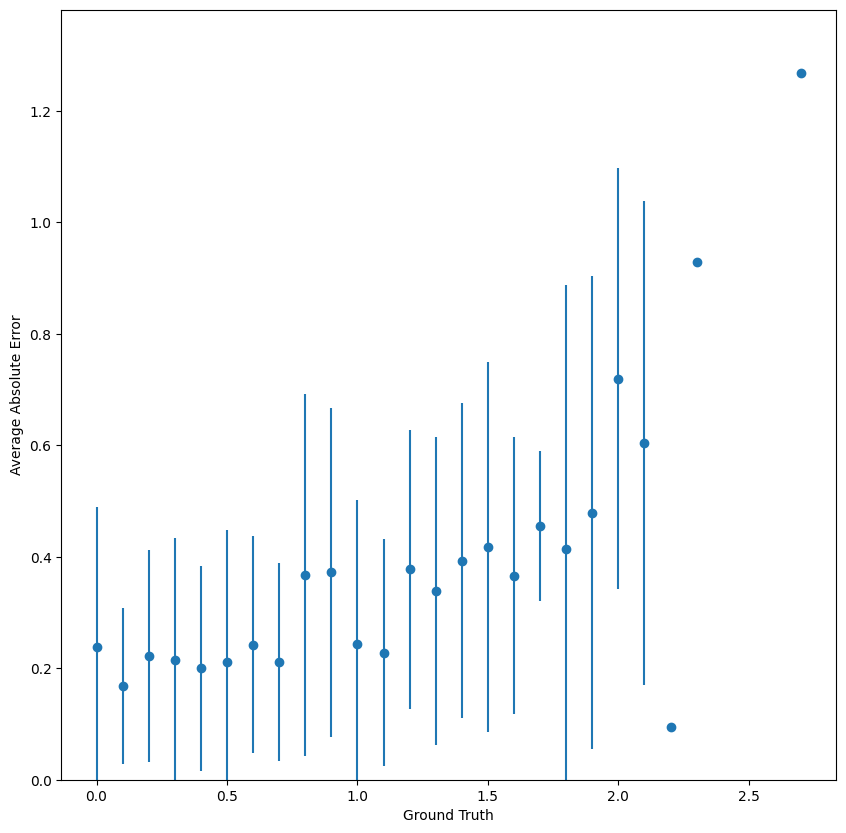

In [56]:
#Make a plot showing the absolute error vs the ground truth value.
#Average over multiple trials with similar ground truth values, using a window size of 0.2.
#The x axis is the ground truth value, and the y axis is the average absolute error.
#The error bars are the standard deviation of the absolute error.
plt.figure(figsize=(10, 10))

def average_error(gt_labels, pred_labels, window_size=0.2):
    # Compute the absolute error
    abs_error = np.abs(gt_labels - pred_labels)
    
    # Compute the average absolute error for each ground truth value
    gt_values = np.arange(0, max(gt_labels), window_size)
    print(gt_values)
    avg_abs_error = []
    std_abs_error = []
    for gt_value in gt_values:
        # Select the absolute error for trials with ground truth values in the current window
        error_in_window = abs_error[(gt_labels >= gt_value) & (gt_labels < gt_value + window_size)]
        # Compute the average absolute error and standard deviation
        if(len(error_in_window) != 0):
            avg_abs_error.append(np.mean(error_in_window))
            std_abs_error.append(np.std(error_in_window))
        else:
            avg_abs_error.append(-1)
            std_abs_error.append(0)
    
    return gt_values, avg_abs_error, std_abs_error

plt.errorbar(*average_error(gt_labels, pred_labels, window_size=0.1), fmt='o')
plt.xlabel('Ground Truth')
plt.ylabel('Average Absolute Error')

#Set lower bound on y axis
plt.ylim(bottom=0)

plt.show()
